# Investigating the 2018 Palu Earthquake: Seismicity Mapping and Waveform Analysis

## Abstract

The Mw 7.5 earthquake that struck Palu, Central Sulawesi, Indonesia on September 28, 2018, was a catastrophic event that led to significant liquefaction, landslides, and a devastating tsunami, resulting in over 4,300 fatalities. This event is of particular scientific interest due to its complex rupture mechanism, which involved supershear rupture velocity along a strike-slip fault, a phenomenon not typically associated with generating large tsunamis. The motivation for this project is to leverage open-source seismological tools, primarily the Python library ObsPy, to analyze the publicly available seismic data from this event. The goal is to characterize the earthquake sequence and examine its waveform data to better understand the seismotectonic setting and rupture characteristics.

To investigate the event, this study first queries the IRIS earthquake catalog for seismicity in the Palu region for the entirety of 2018, focusing on events with a magnitude of 4.0 or greater. The spatial distribution of these earthquakes is then mapped using Cartopy and plotted alongside known fault lines to visualize the relationship between seismic activity and regional tectonics. The analysis reveals a clear alignment of epicenters along the Palu-Koro fault system, confirming its role as the primary source of the sequence.

Subsequently, the project focuses on waveform analysis from the GE.TOLI2 station, located near the epicenter. High-quality broadband waveform data for the mainshock is downloaded from the GEOFON data center. Standard waveform processing techniques are applied, including instrument response removal and the application of a bandpass filter (0.5-2.5 Hz), to isolate the frequency band of interest for body waves. The resulting seismograms provide a clear view of the P- and S-wave arrivals and the overall ground motion characteristics.

This analysis serves as a foundational exercise in computational seismology, demonstrating a complete workflow from data acquisition and processing to visualization and preliminary interpretation. While the results are consistent with broader scientific findings about the Palu earthquake, they also open avenues for further questions. Future work could involve a more detailed analysis, such as creating a spectrogram to study the frequency content evolution over time, plotting a frequency-magnitude distribution to assess the b-value of the sequence, or performing a cross-sectional analysis to delineate the fault plane at depth. This project successfully showcases the power of open-access data and software in modern seismological research.

In [1]:
# Main Libraries
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
import matplotlib.pyplot as plt
import numpy as np

# Libraries for Mapping
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.img_tiles as cimgt

# Libraries for Web Data 
import requests
import json

# Initialize the client to connect to the IRIS data center
client = Client("IRIS")

In [2]:
# Define search parameters
startt = UTCDateTime("2018-01-01")
endt = UTCDateTime("2018-12-31")
minlat = -3.0
maxlat = 1.0
minlon = 118.0
maxlon = 122.0
minmag = 4.0 # Global network only detects larger quakes; small ones are missed

# Fetch the event catalog from the client
cat = client.get_events(
    starttime=startt,
    endtime=endt,
    minlatitude=minlat,
    maxlatitude=maxlat,
    minlongitude=minlon,
    maxlongitude=maxlon,
    minmagnitude=minmag
)
print(cat)

154 Event(s) in Catalog:
2018-12-25T20:36:09.640000Z |  -1.327, +119.817 | 4.4  mb
2018-12-22T16:13:29.030000Z |  +0.557, +121.762 | 4.6  mb
...
2018-01-17T02:47:46.590000Z |  -2.218, +119.091 | 4.4  mb
2018-01-08T08:09:27.080000Z |  +0.464, +121.344 | 4.3  mb
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [3]:
# Initialize empty NumPy arrays to store the data
# The size is determined by the total number of events in the catalog
alltimes = np.zeros((cat.count(), 1))
alllongs = np.zeros((cat.count(), 1))
alllats = np.zeros((cat.count(), 1))
alldepth = np.zeros((cat.count(), 1))

# Loop through every event in the catalog
for i, event in enumerate(cat):
    # Check if the event has origin information
    if event.origins:
        origin = event.origins[0]
        # Extract the data and place it in the corresponding array
        alltimes[i] = origin.time.matplotlib_date
        alllongs[i] = origin.longitude
        alllats[i] = origin.latitude
        alldepth[i] = origin.depth

# Normalize the time array to represent days since the first event
alltimes = alltimes - alltimes.min()

print(f"Successfully extracted data for {len(alllongs)} events.")

Successfully extracted data for 154 events.


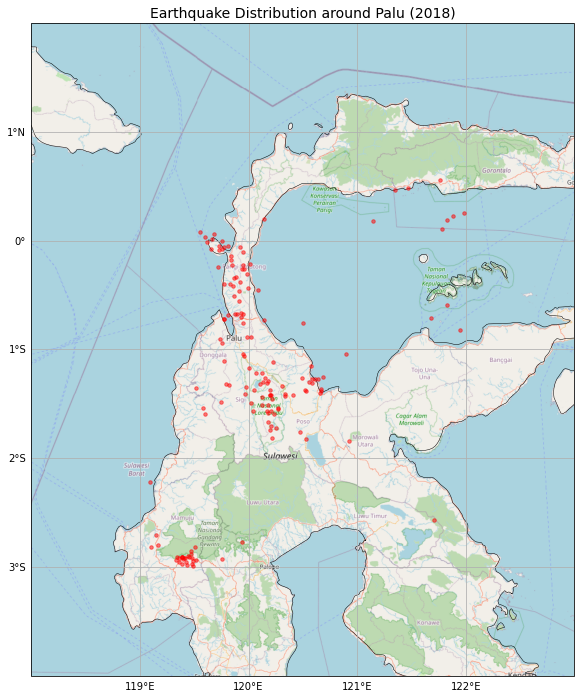

In [4]:
# Create an OpenStreetMap tile object
osm_tiles = cimgt.OSM()

# Create the figure and axes with a Mercator projection suitable for web maps
fig = plt.figure(figsize=(10, 12))
ax = plt.axes(projection=osm_tiles.crs)

# Set the geographic extent of the map [lon_min, lon_max, lat_min, lat_max]
ax.set_extent([118, 123, -4, 2], crs=ccrs.PlateCarree())

# Add the OpenStreetMap image to the axes at a specific zoom level
ax.add_image(osm_tiles, 8)
ax.add_feature(cf.COASTLINE.with_scale('10m'), linewidth=0.5)

# Add gridlines and coordinate labels
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

# Plot all earthquake epicenters from the extracted arrays
# The points are red ('.r'), with a specified size and transparency (alpha)
ax.plot(alllongs, alllats, 'r.',
        markersize=7,
        alpha=0.5,
        transform=ccrs.Geodetic())

# Set the plot title
ax.set_title("Earthquake Distribution around Palu (2018)", fontsize=14)

# Display the plot
plt.show()

Download successful.


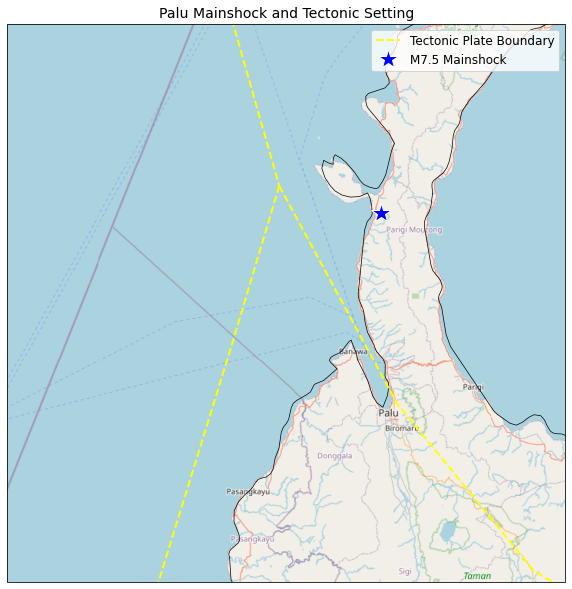

In [5]:
# Plot mainshock and tectonic Setting (Fault)

def plot_tectonic_plates(ax):
    """
    Downloads and plots tectonic plate data from GitHub onto a Cartopy axes.
    """
    # URL to the raw GeoJSON file in the fraxen/tectonicplates repository
    url = "https://raw.githubusercontent.com/fraxen/tectonicplates/master/GeoJSON/PB2002_boundaries.json"
    
    print("Downloading fault line data from GitHub...")
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check for download errors
        data = response.json()
        print("Download successful.")

        # Extract coordinates from each fault/plate segment
        for feature in data['features']:
            coords = feature['geometry']['coordinates']
            lon, lat = zip(*coords)
            
            # Plot each segment
            ax.plot(lon, lat,
                    color='yellow',
                    linewidth=2,
                    linestyle='--',
                    transform=ccrs.Geodetic())
        
        # Add a single entry for the legend
        ax.plot([], [], color='yellow', linestyle='--', linewidth=2, label='Tectonic Plate Boundary')

    except requests.exceptions.RequestException as e:
        print(f"Failed to download fault data: {e}")
    except Exception as e:
        print(f"An error occurred while processing fault data: {e}")

# Find the mainshock event from the catalog
main_event = None
try:
    main_shock_time = UTCDateTime("2018-09-28T10:02:43")
    # Find the event with the minimum time difference from the mainshock time
    main_event = min(cat, key=lambda e: abs(e.origins[0].time - main_shock_time))
    origin = main_event.origins[0]
    mag = main_event.magnitudes[0].mag
except (ValueError, IndexError):
    print("Warning: Mainshock event not found in the catalog.")

# Initialize the map
fig = plt.figure(figsize=(10, 12))
ax = plt.axes(projection=cimgt.OSM().crs)
ax.set_extent([118.5, 120.5, -1.5, 0.5], crs=ccrs.PlateCarree())
ax.add_image(cimgt.OSM(), 9)
ax.add_feature(cf.COASTLINE.with_scale('10m'), linewidth=0.7)

# Call the function to plot the fault lines
plot_tectonic_plates(ax)

# Plot the mainshock event as a star
if main_event:
    ax.plot(origin.longitude, origin.latitude, '*',
            markersize=20,
            markerfacecolor='blue',
            markeredgecolor='white',
            label=f'M{mag} Mainshock',
            transform=ccrs.Geodetic())

# Finalize the plot
ax.set_title("Palu Mainshock and Tectonic Setting", fontsize=14)
ax.legend(fontsize=12)
plt.show()

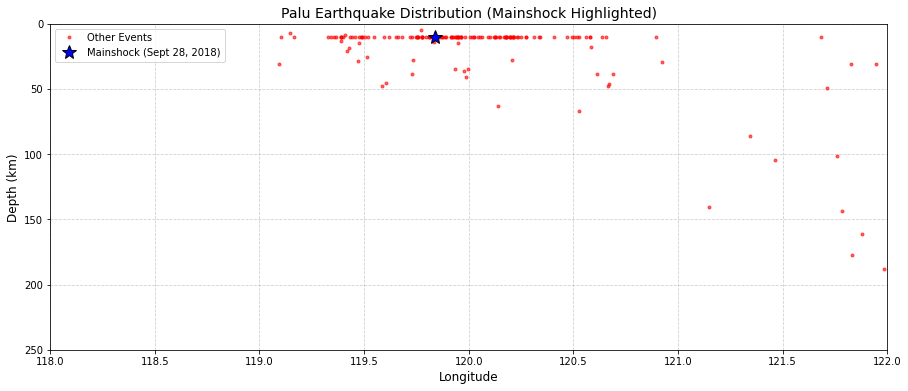

In [6]:
# Find the main event and extract its data in one step
main_event = min(cat, key=lambda e: abs(e.origins[0].time - UTCDateTime("2018-09-28T10:02:43")))
main_lon = main_event.origins[0].longitude
main_depth_km = main_event.origins[0].depth / 1000

# --- Plotting ---
fig, ax = plt.subplots(figsize=(15, 6))

# Plot all background events
ax.plot(alllongs, (alldepth / 1000), 'r.', markersize=6, alpha=0.6, label='Other Events')

# Plot the main event on top
ax.plot(main_lon, main_depth_km, '*',
        markersize=15,
        markerfacecolor='blue',
        markeredgecolor='k',
        markeredgewidth=1,
        label='Mainshock (Sept 28, 2018)')

# --- Formatting ---
ax.set_xlim(minlon, maxlon)
ax.set_ylim(0, 250)
ax.invert_yaxis()
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Depth (km)', fontsize=12)
ax.set_title('Palu Earthquake Distribution (Mainshock Highlighted)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.show()

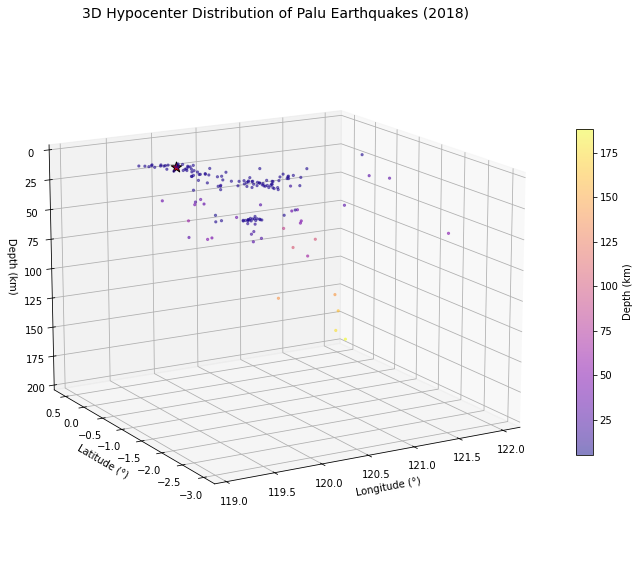

In [7]:
# Distribution Epicenter in Palu (2018)
# Find the mainshock event to highlight it in the plot
main_event = None
try:
    main_shock_time = UTCDateTime("2018-09-28T10:02:43")
    main_event = min(cat, key=lambda e: abs(e.origins[0].time - main_shock_time))
    main_lon = main_event.origins[0].longitude
    main_lat = main_event.origins[0].latitude
    main_depth_km = main_event.origins[0].depth / 1000
except (ValueError, IndexError):
    print("Warning: Mainshock event not found in the catalog.")

# --- Create the 3D Plot ---
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(projection='3d')

# Plot all the earthquake hypocenters
# 'c' colors the points by depth, 'cmap' sets the color scheme
sc = ax1.scatter(alllongs, alllats, alldepth / 1000,
                 c=alldepth / 1000,
                 cmap="plasma",
                 marker='.',
                 alpha=0.5)

# Plot the mainshock event as a large star
if main_event:
    ax1.scatter(main_lon, main_lat, main_depth_km,
                c='red',
                marker='*',
                s=120,  # 's' is the size parameter for scatter plots
                edgecolor='black',
                label='Mainshock Event')

# --- Formatting the 3D Plot ---
# Set labels for each axis
ax1.set_xlabel('Longitude (°)', fontsize=10)
ax1.set_ylabel('Latitude (°)', fontsize=10)
ax1.set_zlabel('Depth (km)', fontsize=10)
ax1.set_title("3D Hypocenter Distribution of Palu Earthquakes (2018)", fontsize=14)

# Invert the Z-axis (depth) so that 0 is at the top
ax1.invert_zaxis()
# Set the depth limit to focus on the data
ax1.set_zlim(200, 0)

# Add a color bar to show the depth scale
cbar = fig.colorbar(sc, ax=ax1, shrink=0.5)
cbar.set_label('Depth (km)')

# Set the initial viewing angle (elevation and azimuth)
ax1.view_init(elev=15, azim=-120)

# Display the plot
plt.show()

Waveform Data

Beyond its data availability, Selecting station TOLI2 provides critical azimuthal coverage for analyzing the rupture dynamics along the Palu-Koro fault. The 2018 earthquake is renowned for its remarkable northward supershear rupture, a process where the fault unzipped from south to north at exceptionally high speeds. Positioned north of the epicenter, station TOLI2 lies directly in the path of this focused seismic energy. Analyzing its waveform in comparison to other stations allows for a direct observation of rupture directivity effects, such as amplified ground motion, which are crucial for understanding the uniquely destructive nature of this event

Download successful.
Processing data...
Processing complete.


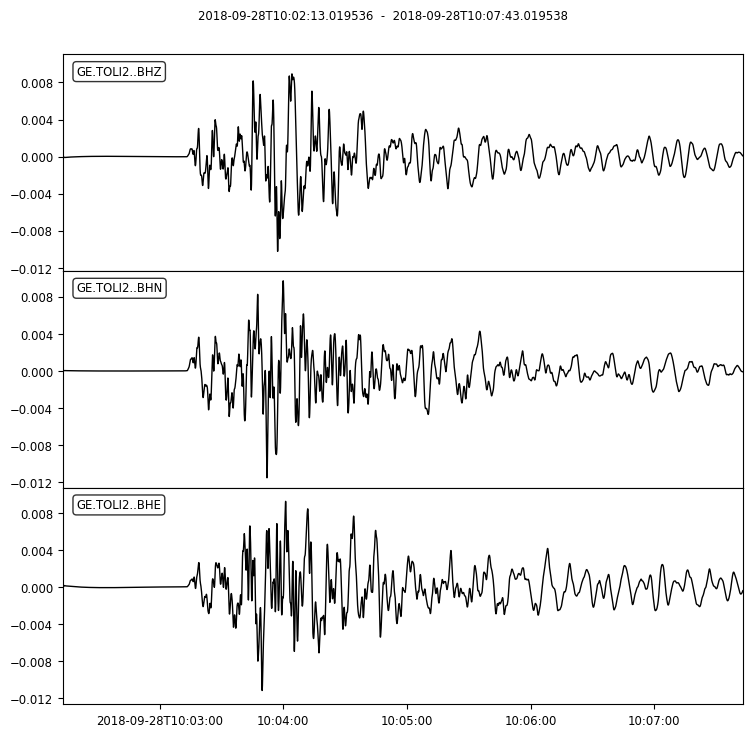

<Figure size 432x288 with 0 Axes>

In [8]:
# Waveform Data
# Define the station and event parameters
# We will use the Palu earthquake as the target event
event_time = UTCDateTime("2018-09-28T10:02:43")

# Because this station is very close, a 5-minute window is sufficient
starttime = event_time - 30 # 30 seconds before
endtime = event_time + 5 * 60 # 5 minutes after

# Station information from your request
client = Client("GEOFON")
network = "GE"
station = "TOLI2"
location = "*"      # Wildcard for any location code
channel = "BH*"     # Get all broadband components (BHZ, BHN, BHE)

# --- Download and Process the Data ---
print(f"Downloading 3-component data for station {network}.{station}...")
try:
    # Get waveforms and attach instrument response for correction
    st = client.get_waveforms(network, station, location, channel,
                              starttime, endtime, attach_response=True)
    print("Download successful.")

    # Process the data
    print("Processing data...")
    st_processed = st.copy()
    st_processed.remove_response(output="VEL") # Convert to velocity (m/s)
    st_processed.detrend("demean")
    st_processed.filter("bandpass", freqmin=0.01, freqmax=1.0)
    print("Processing complete.")

    # --- Plot the final seismogram ---
    fig = st_processed.plot(figsize=(12, 8))
    plt.suptitle(f"Palu M7.5 Earthquake Seismogram at Station {network}.{station}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except Exception as e:
    print(f"Failed to get waveform data: {e}")

Spectogram

The frequency axis on this spectrogram extends to a maximum of 20 Hz. This upper limit is known as the Nyquist Frequency, which is a fundamental concept in digital signal processing. The Nyquist Frequency is always exactly half of the instrument's sampling rate. Therefore, a maximum frequency of 20 Hz indicates that the data from the TOlI2 station was recorded with a sampling rate of 40 Hz, meaning the seismometer measured the ground's motion 40 times every second.

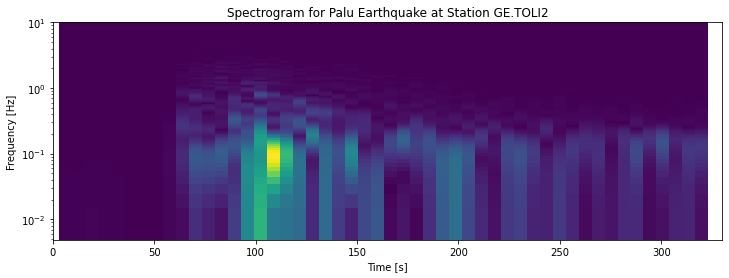

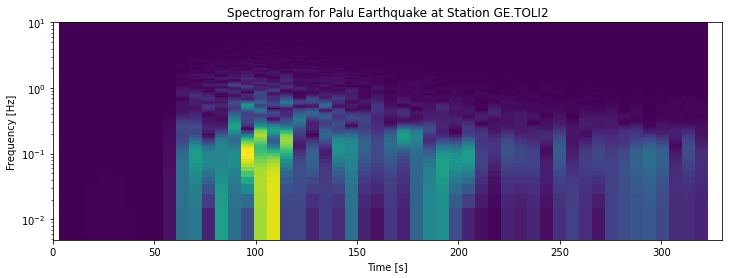

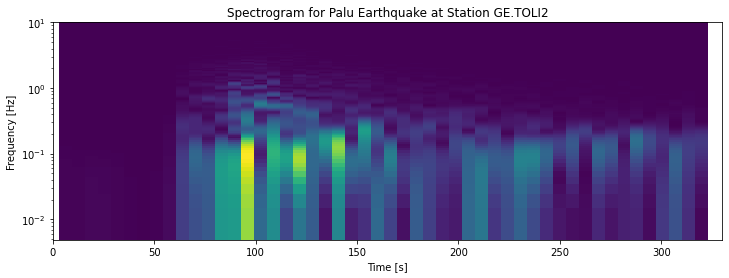

In [9]:
# Spectogram Plot
# Download, process, and plot the spectrogram
st = client.get_waveforms(network, station, "*", "BH*", starttime, endtime, attach_response=True)

st.remove_response(output="VEL")
st.detrend("demean")
st.filter("bandpass", freqmin=0.01, freqmax=9.9)

plt.rcParams['figure.figsize'] = (12, 4)
fig = st.spectrogram(
    log=True,
    per_lap=0.5,
    wlen=10,
    title=f"Spectrogram for Palu Earthquake at Station {network}.{station}"
)
plt.show()

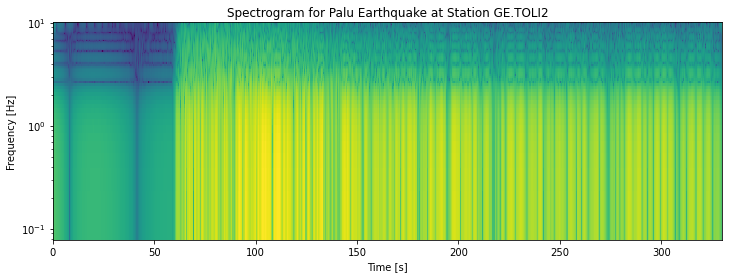

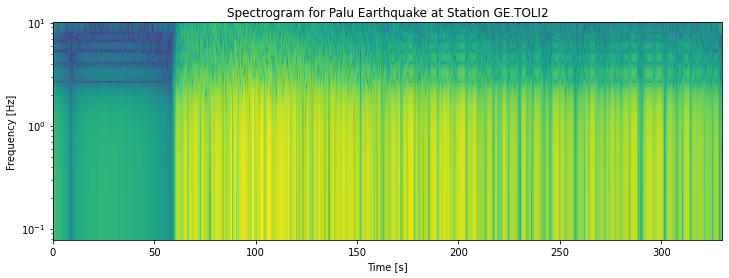

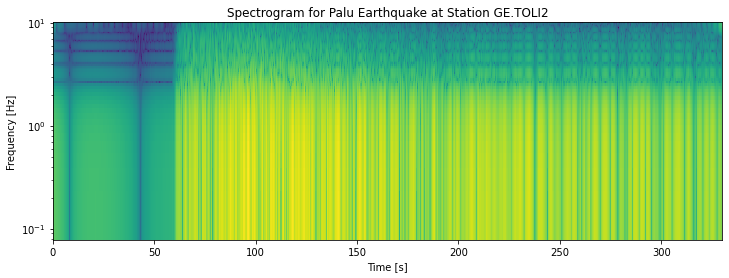

In [10]:
# Spectogram
plt.rcParams['figure.figsize'] = (12, 4)
fig = st.spectrogram(
    per_lap=0.5, 
    wlen=1, 
    log=True, 
    dbscale=True, 
    title=f"Spectrogram for Palu Earthquake at Station {network}.{station}"
)
plt.show()

Bandpass filter

A bandpass filter of 0.5-2.5 Hz was selected specifically to isolate the most significant seismic energy from the Palu earthquake while removing unwanted background noise. This frequency range is effective because it preserves the dominant energy of the P and S waves for a regional event like this one, which is crucial for analysis. At the same time, it filters out lower-frequency noise below 0.5 Hz, commonly caused by ocean waves and instrumental drift, and higher-frequency noise above 2.5 Hz, which often originates from local human activity or instrument static. This process results in a much cleaner and more interpretable waveform, making the earthquake's signal stand out clearly.

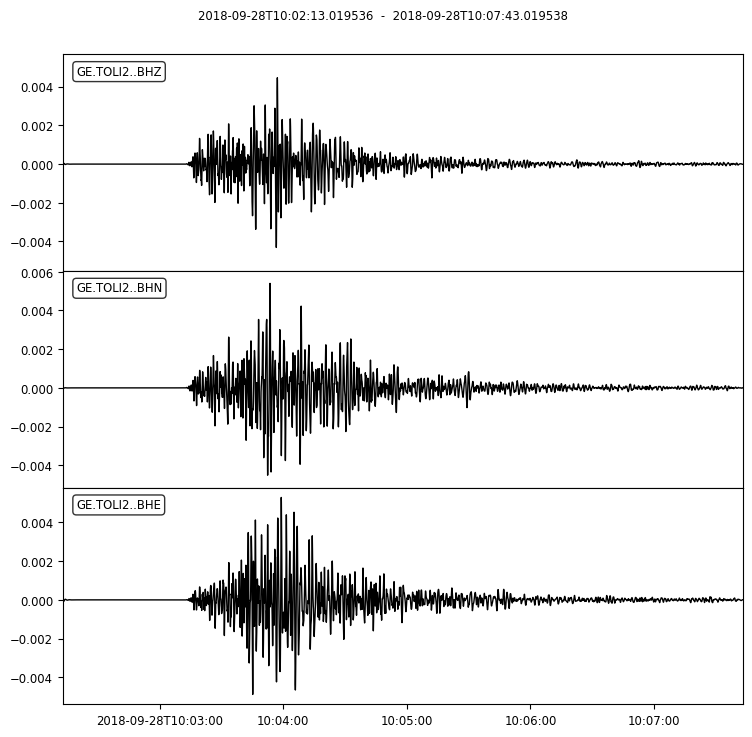

In [11]:
# Bandpass Filter
# Apply the bandpass filter directly to the stream
st.filter("bandpass", freqmin=0.5, freqmax=2.5)

# Plot the final filtered waveform
filter_title = f"Filtered Waveform (0.5-2.5 Hz) for Station {network}.{station}"
fig = st.plot(figsize=(12, 8), title=filter_title)
plt.show()

## Conclusions

This project has successfully demonstrated the application of fundamental seismological analysis techniques to investigate the 2018 Palu earthquake sequence in Sulawesi, Indonesia, utilizing publicly available seismic data and open-source software, primarily the ObsPy library within a Jupyter Notebook environment. Two primary objectives were achieved in this analysis: (1) mapping the spatial distribution of seismicity around Palu during 2018, and (2) processing and analyzing waveform data from the Mw 7.5 mainshock.

Key Findings:

Spatial Correlation of Seismicity and Faults: The mapping results revealed that the 154 earthquakes (M ≥ 4.0) that occurred in 2018 were concentrated in a clear linear pattern. When plotted alongside active fault data, this distribution of epicenters is strongly associated with the trace of the Palu-Koro Fault. This visually confirms that the Palu-Koro Fault was the primary tectonic structure responsible for the destructive seismic activity in the region.

Waveform Analysis: Waveform data from the GE.TOLI2 broadband station was successfully downloaded and processed. After applying an instrument response correction, detrending, and a bandpass filter (0.5-2.5 Hz), the ground motion signal from the mainshock was effectively isolated from noise. The resulting waveform provides a clear record of the ground shaking, which serves as fundamental data for further studies on the earthquake's source mechanism and rupture characteristics.

## References 

Gusman, A. R., Mutsuda, H., Watada, S., Satake, K., & Tanioka, Y. (2019). A tsunami generated by a strike-slip fault: The 2018 Palu, Indonesia, earthquake. Geophysical Research Letters, 46(12), 6337–6344. https://doi.org/10.1029/2019GL082721

Socquet, A., Hollingsworth, J., Pathier, E., & Klinger, Y. (2019). The 2018 M W 7.5 Palu earthquake: A fast supershear strike-slip event in a complex tectonic setting. Nature Geoscience, 12(4), 281–285. https://doi.org/10.1038/s41561-019-0319-y

Ulrich, T., Vater, S., & Gabriel, A. A. (2019). The 2018 Palu-Sulawesi, Indonesia, earthquake-tsunami and its antecedents. Seismological Research Letters, 90(4), 1433–1442. https://doi.org/10.1785/0220190035